# Lag Definition

In [1]:
## Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy import stats
from tqdm import tqdm

In [2]:
pop = {'RS': 11422973,
  'SC': 7252502,
  'DF': 3055149,
  'MG': 21292666,
  'SP': 46289333,
  'RN': 3534165,
  'GO': 7113540,
  'AM': 4207714,
  'PA': 8690745,
  'PE': 9616621,
  'PB': 4039277,
  'ES': 4064052,
  'AP': 861773,
  'TO': 1590248,
  'MT': 3526220,
  'PR': 11516840,
  'PI': 3281480,
  'RR': 631181,
  'BA': 14930634,
  'CE': 9187103,
  'RJ': 17366189,
  'AC': 894470,
  'MA': 7114598,
  'AL': 3351543,
  'RO': 1796460,
  'MS': 2809394,
  'SE': 2318822}

In [3]:
## Import Data

estados = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

df_dict_uf = {uf:pd.read_csv('data_preparation_new_csv\%s.csv'%uf, parse_dates = ['data']).set_index(['data'], drop = True) for uf in estados}

cluster_uf = pd.Series({'AC': 1,
 'AL': 0,
 'AM': 1,
 'AP': 1,
 'BA': 0,
 'CE': 0,
 'DF': 0,
 'ES': 0,
 'GO': 0,
 'MA': 1,
 'MG': 0,
 'MS': 2,
 'MT': 0,
 'PA': 1,
 'PB': 0,
 'PE': 0,
 'PI': 0,
 'PR': 0,
 'RJ': 0,
 'RN': 0,
 'RO': 0,
 'RR': 1,
 'RS': 0,
 'SC': 0,
 'SE': 0,
 'SP': 2,
 'TO': 0}) #a14 24/3

In [4]:
def shift(lag):
    for i,uf in enumerate(estados):
        iteration = df_dict_uf[uf][var_y + var_X + ['cluster']].copy().reset_index()
        iteration[var_X] = iteration[var_X].shift(lag)
        iteration['uf'] = uf
        iteration = iteration[iteration.data >= (pd.to_datetime('2021-01-16')) + pd.to_timedelta(lag,unit='D')]
        if i == 0:
            data = iteration
        else:
            data = pd.concat([data,iteration], ignore_index = True)


    for col in google_var:
        abs_max = np.abs(data[col]).max()
        data[col] = data[col] / abs_max

    for col in var_X:
        data[col] = 2 * ((data[col] - data[col].min())/(data[col].max() - data[col].min())) - 1

    return data

<AxesSubplot:>

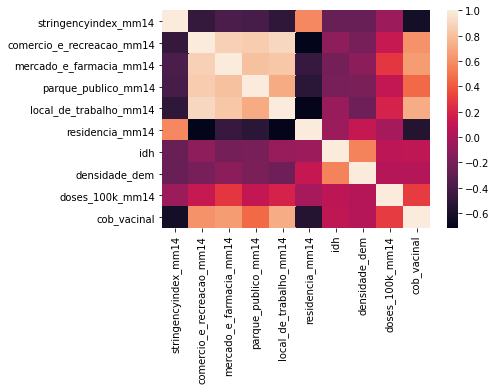

In [5]:
## Independent Variables Correlation Matrix

var_X = ['stringencyindex_mm14',
       'comercio_e_recreacao_mm14', 'mercado_e_farmacia_mm14',
       'parque_publico_mm14', 'local_de_trabalho_mm14',
       'residencia_mm14', 'idh', 'densidade_dem', 'doses_100k_mm14','cob_vacinal']
google_var = ['comercio_e_recreacao_mm14', 'mercado_e_farmacia_mm14',
       'parque_publico_mm14', 'local_de_trabalho_mm14',
       'residencia_mm14']

for i,uf in enumerate(estados):
    iteration = df_dict_uf[uf].reset_index()
    iteration = iteration[iteration.data >= pd.to_datetime('2021-01-16')]
    if i == 0:
        data = iteration
    else:
        data = pd.concat([data,iteration], ignore_index = True)

correl = data[var_X].corr()
sns.heatmap(correl)

## LAG DEFINITION

In [6]:
## Define Dependent Variable

var_y = ['obitos_100k_mm14']

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


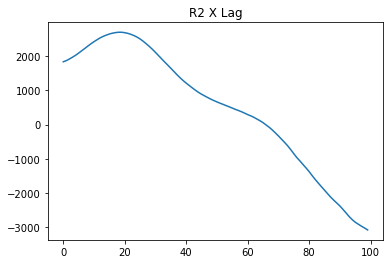

In [7]:
## Lag Scores

lag_scores = list()
for lag in tqdm(range(100)):
    for i,uf in enumerate(pop):
        iteration = df_dict_uf[uf][var_y + var_X + ['cluster']].copy().reset_index()
        iteration['uf'] = uf
        iteration[var_X] = iteration[var_X].shift(lag)
        iteration = iteration[iteration.data >= (pd.to_datetime('2021-01-16')) + pd.to_timedelta(lag,unit='D')]
        
        if i == 0:
            data = iteration
        else:
            data = pd.concat([data,iteration], ignore_index = True)
            
    data[var_X] = 2 * (data[var_X] - data[var_X].min())/(data[var_X].max() - data[var_X].min()) - 1
            
    X = data[var_X]
    y = data[var_y]
    
    est = sm.OLS(y, sm.add_constant(X)).fit()
    
    lag_scores.append(est.bic)
        

plt.plot(range(100),lag_scores)
plt.title('R2 X Lag')
plt.show()


In [8]:
lag = np.argmax(lag_scores)
lag

18

## feature selection for LM with no cluster

In [9]:
def backwiseselection(X,y,selected_variables = X.columns,alfa = 0.05):
    #never fill selected_variables argument, it is used for recursion only#
    est = sm.OLS(y, sm.add_constant(X[selected_variables])).fit()
    p_values = est.pvalues.drop('const')
    if len(p_values[p_values < alfa]) == len(selected_variables):
        return selected_variables
    else:
        selected = selected_variables.drop(est.pvalues.drop('const').idxmax())
        return backwiseselection(X,y,selected,alfa)

In [10]:
X = shift(lag)[var_X]
y = shift(lag)[var_y]

for alfa in [0.001,0.01,0.05,0.1,1]:
    print("\n for alfa = %.3f, the eliminated features are: \n"%alfa)
    for feature in var_X:
        if feature not in backwiseselection(X,y,alfa = alfa):
            print(feature)


 for alfa = 0.001, the eliminated features are: 

mercado_e_farmacia_mm14
parque_publico_mm14

 for alfa = 0.010, the eliminated features are: 

parque_publico_mm14

 for alfa = 0.050, the eliminated features are: 

parque_publico_mm14

 for alfa = 0.100, the eliminated features are: 

parque_publico_mm14

 for alfa = 1.000, the eliminated features are: 



## LM with no cluster

In [11]:
coefs = {cluster : pd.DataFrame(columns = ['LB','Betha','UB'], index = ['const'] + var_X, data = 0) for cluster in ['all',0,1,2]}

In [12]:
selected_X = X[backwiseselection(X,y,alfa = 0.05)]
y = y

In [13]:
#Linear Regression
est = sm.OLS(y, sm.add_constant(selected_X)).fit()

coefs['all'].loc[np.concatenate((['const'],np.array(selected_X.columns))),'Betha'] = est.params
coefs['all'].loc[np.concatenate((['const'],np.array(selected_X.columns))),'LB'] = est.conf_int(alpha = 0.05)[0]
coefs['all'].loc[np.concatenate((['const'],np.array(selected_X.columns))),'UB'] = est.conf_int(alpha = 0.05)[1]
coefs['all'].fillna(0,inplace=True)
   
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:       obitos_100k_mm14   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     1139.
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        22:54:44   Log-Likelihood:                -1303.5
No. Observations:                7290   AIC:                             2627.
Df Residuals:                    7280   BIC:                             2696.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [14]:
coefs['all']

,LB,Betha,UB
const,0.387806,0.411037,0.434268
stringencyindex_mm14,-0.123864,-0.098290,-0.072716
comercio_e_recreacao_mm14,-0.303193,-0.240373,-0.177552
mercado_e_farmacia_mm14,0.030278,0.080859,0.131440
parque_publico_mm14,0.000000,0.000000,0.000000
local_de_trabalho_mm14,-0.239880,-0.176274,-0.112668
residencia_mm14,0.200546,0.242402,0.284258
idh,0.360342,0.378696,0.397049
densidade_dem,-0.198944,-0.177987,-0.157029
doses_100k_mm14,-0.111852,-0.086548,-0.061244


## Linear Regressions for Clusters 

In [15]:
ests = list()
for k in cluster_uf.unique():
    
    data = shift(lag)
    X = data[data['cluster']==k][var_X]
    y = data[data['cluster']==k][var_y]

    print('\n for cluster \n', k)

    
    
    X_variables = backwiseselection(X,y,alfa = 0.05)

    selected_X = X[X_variables]
    y = y[var_y]
    
    print("removed variables for cluster k are:")
    for feature in var_X:
        if feature not in X_variables:
            print(feature)


    
    est = sm.OLS(y, sm.add_constant(selected_X)).fit()
    ests.append(est)
    
    
    coefs[k].loc[np.concatenate((['const'],np.array(X_variables))),'Betha'] = est.params
    coefs[k].loc[np.concatenate((['const'],np.array(X_variables))),'LB'] = est.conf_int(alpha = 0.05)[0]
    coefs[k].loc[np.concatenate((['const'],np.array(X_variables))),'UB'] = est.conf_int(alpha = 0.05)[1]
    coefs[k].fillna(0,inplace=True)

    print(est.summary())



 for cluster 
 1
removed variables for cluster k are:
local_de_trabalho_mm14
                            OLS Regression Results                            
Dep. Variable:       obitos_100k_mm14   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     418.9
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        22:54:44   Log-Likelihood:                 210.12
No. Observations:                1620   AIC:                            -400.2
Df Residuals:                    1610   BIC:                            -346.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## graphic analysis

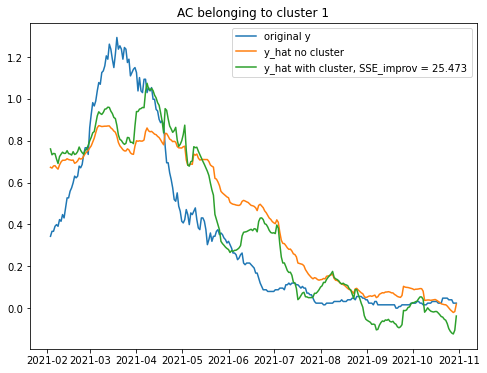

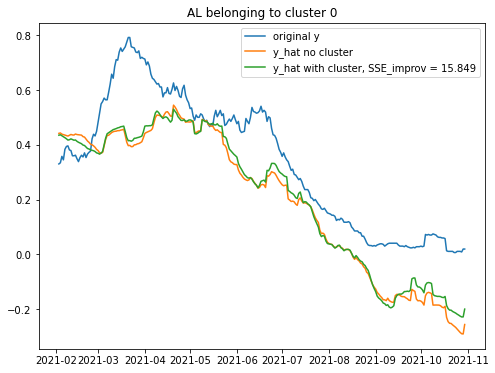

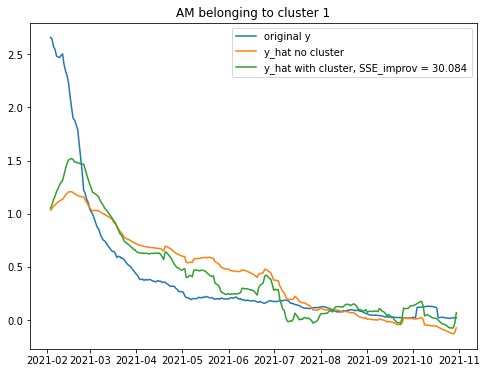

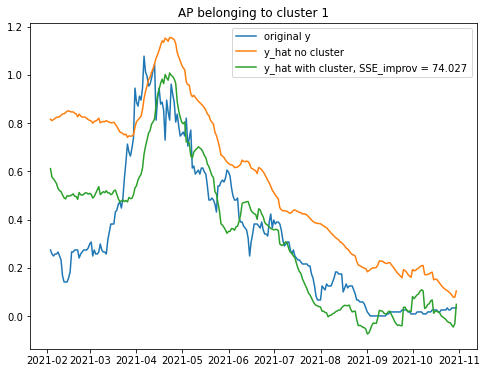

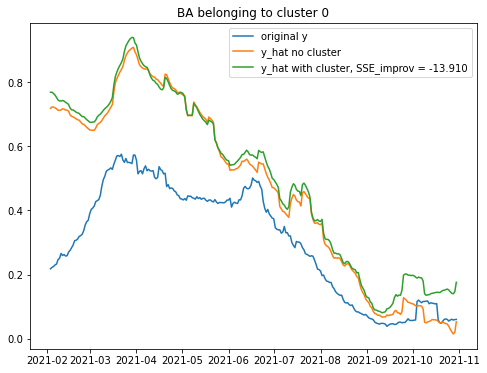

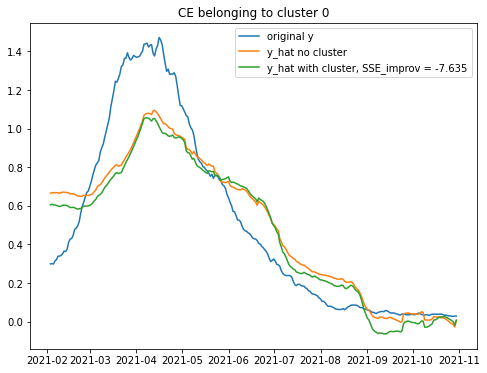

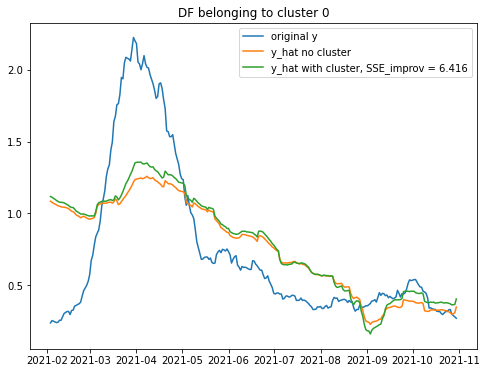

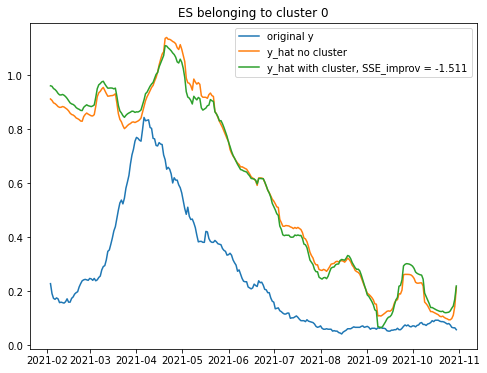

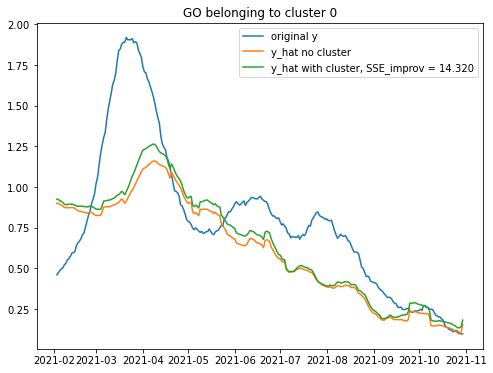

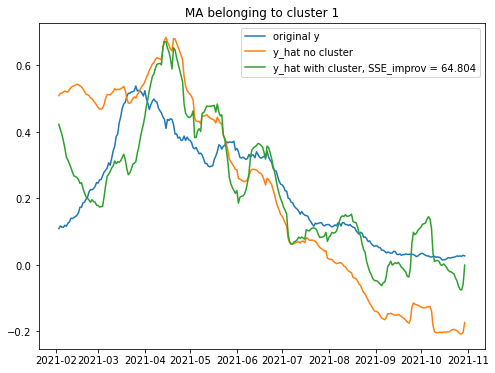

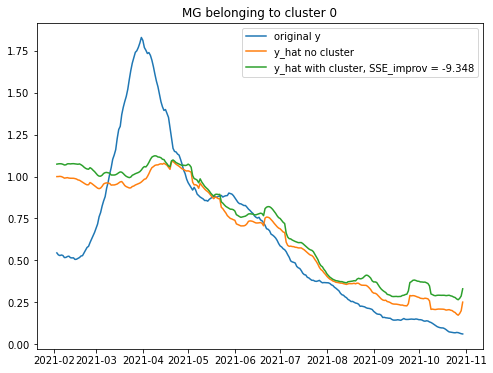

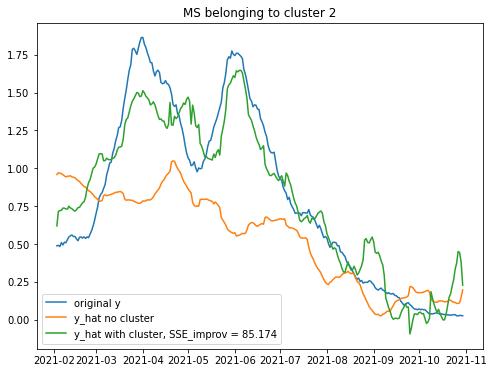

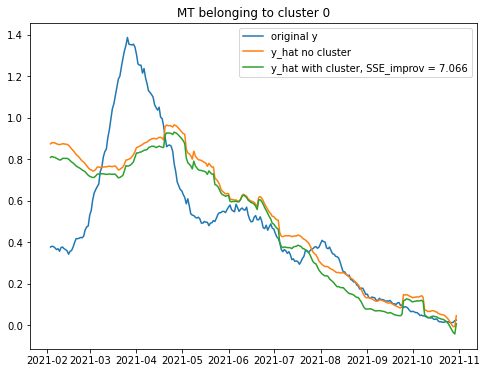

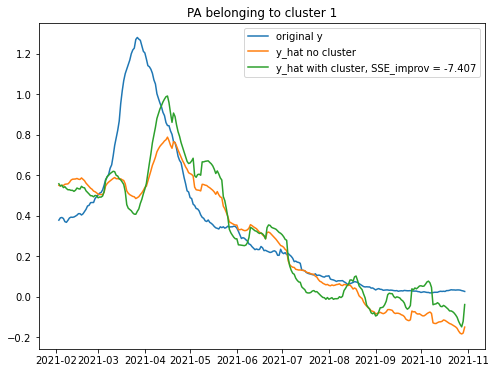

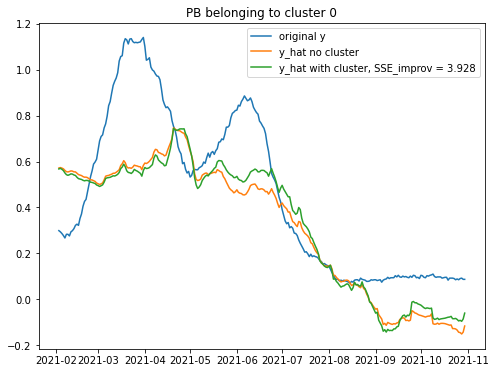

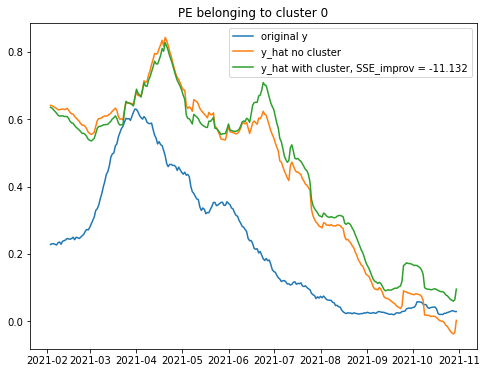

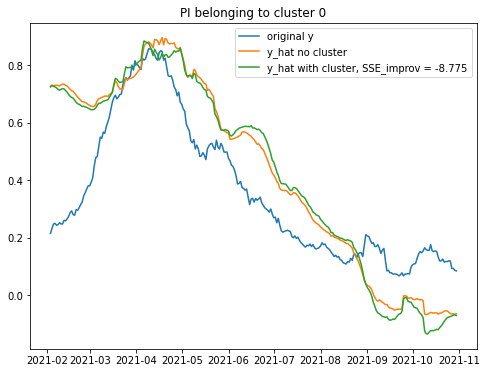

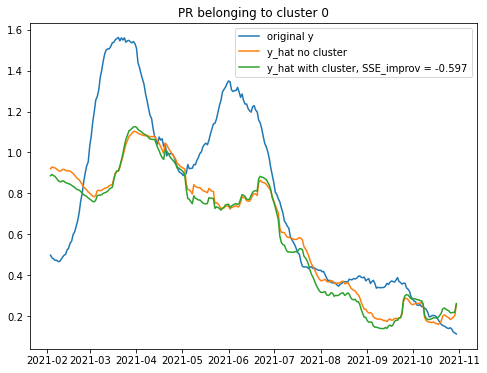

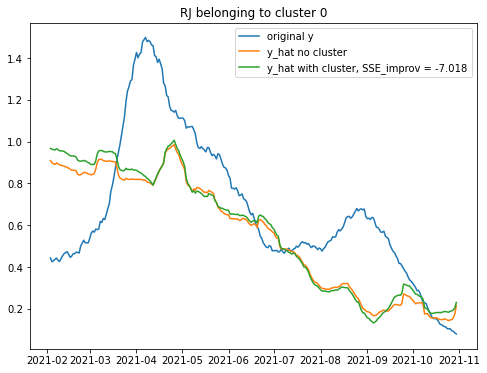

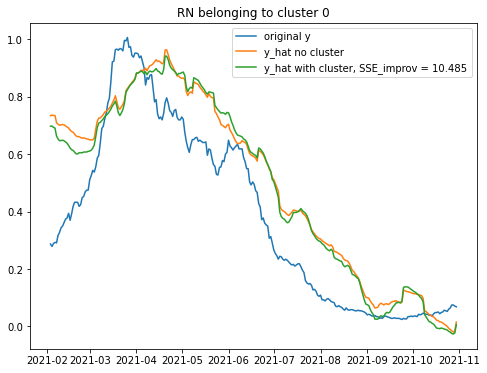

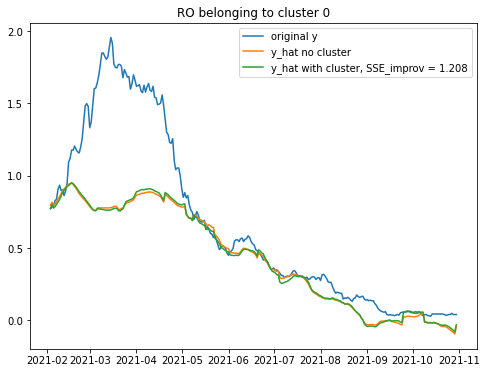

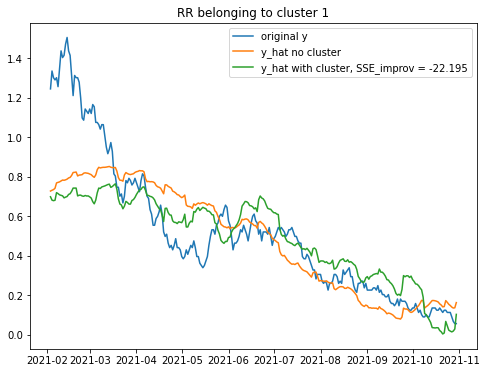

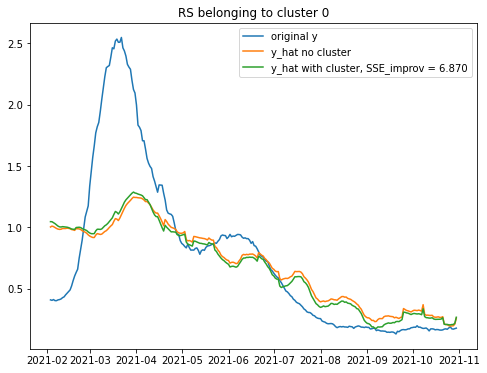

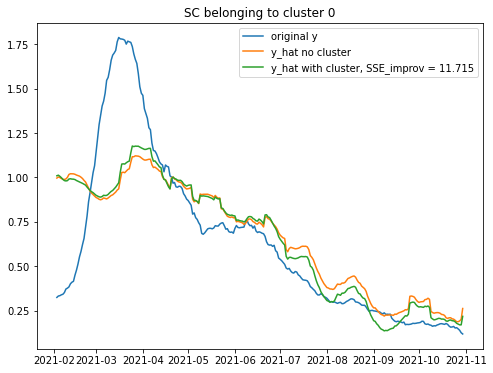

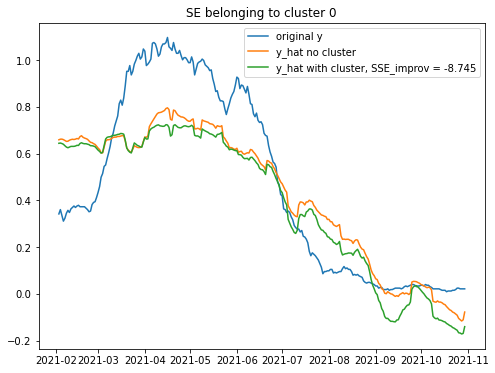

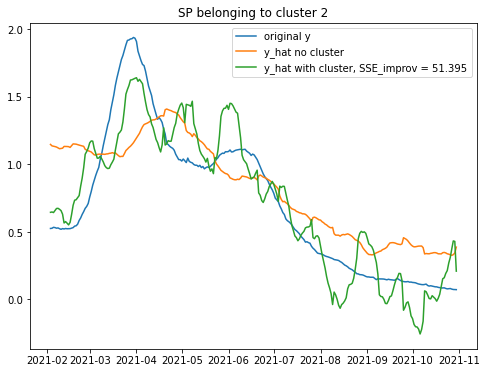

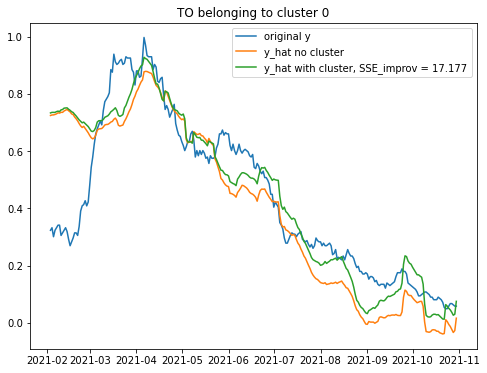

In [16]:
for uf in estados:
    k = cluster_uf[uf]
    real_curve = data[data['uf'] == uf].set_index('data',drop=True)[var_y]
    parameters_values = data[data['uf'] == uf].set_index('data',drop=True)[var_X]
    estimated_curve_all = (coefs['all']['Betha'][1:] * parameters_values[var_X]).sum(axis=1) + coefs['all'].loc['const','Betha']
    estimated_curve_cluster = (coefs[k]['Betha'][1:] * parameters_values[var_X]).sum(axis=1) + coefs[k].loc['const','Betha']
    
    
    SSE_all = mean_squared_error(estimated_curve_all,real_curve)
    SSE_cluster = mean_squared_error(estimated_curve_cluster,real_curve)
    ratio = -100 * ((SSE_cluster/ SSE_all) - 1)

    # Just a figure and one subplot
    f, ax = plt.subplots(figsize = (8,6))

    ax.set_title(uf + " belonging to cluster %s"%k)
    ax.plot(real_curve, label="original y")
    ax.plot(estimated_curve_all, label="y_hat no cluster")
    ax.plot(estimated_curve_cluster, label="y_hat with cluster, SSE_improv = %.3f"%ratio)
    ax.legend()
    plt.savefig("graf_final%s.png"%uf)
    plt.show()

In [18]:
coefs[0].T

,const,stringencyindex_mm14,comercio_e_recreacao_mm14,mercado_e_farmacia_mm14,parque_publico_mm14,local_de_trabalho_mm14,residencia_mm14,idh,densidade_dem,doses_100k_mm14,cob_vacinal
LB,0.325769,-0.216660,-0.717699,0.242835,0.056051,-0.271143,0.053364,0.406703,-0.240698,-0.170468,-0.370908
Betha,0.358383,-0.184649,-0.612726,0.307178,0.107406,-0.177294,0.112183,0.428215,-0.217601,-0.139839,-0.345342
UB,0.390998,-0.152638,-0.507752,0.371521,0.158761,-0.083446,0.171003,0.449726,-0.194504,-0.109211,-0.319776


In [21]:
tips = sns.load_dataset("tips")

In [28]:
coefs[0]

,LB,Betha,UB
const,0.325769,0.358383,0.390998
stringencyindex_mm14,-0.216660,-0.184649,-0.152638
comercio_e_recreacao_mm14,-0.717699,-0.612726,-0.507752
mercado_e_farmacia_mm14,0.242835,0.307178,0.371521
parque_publico_mm14,0.056051,0.107406,0.158761
local_de_trabalho_mm14,-0.271143,-0.177294,-0.083446
residencia_mm14,0.053364,0.112183,0.171003
idh,0.406703,0.428215,0.449726
densidade_dem,-0.240698,-0.217601,-0.194504
doses_100k_mm14,-0.170468,-0.139839,-0.109211


In [38]:
a = pd.concat([coefs[0].LB,coefs[0].UB])

In [40]:
a.reset_index()

,index,0
0,const,0.325769
1,stringencyindex_mm14,-0.216660
2,comercio_e_recreacao_mm14,-0.717699
3,mercado_e_farmacia_mm14,0.242835
4,parque_publico_mm14,0.056051
5,local_de_trabalho_mm14,-0.271143
6,residencia_mm14,0.053364
7,idh,0.406703
8,densidade_dem,-0.240698
9,doses_100k_mm14,-0.170468


In [49]:
a

const                        0.325769
stringencyindex_mm14         -0.21666
comercio_e_recreacao_mm14   -0.717699
mercado_e_farmacia_mm14      0.242835
parque_publico_mm14          0.056051
local_de_trabalho_mm14      -0.271143
residencia_mm14              0.053364
idh                          0.406703
densidade_dem               -0.240698
doses_100k_mm14             -0.170468
cob_vacinal                 -0.370908
const                        0.390998
stringencyindex_mm14        -0.152638
comercio_e_recreacao_mm14   -0.507752
mercado_e_farmacia_mm14      0.371521
parque_publico_mm14          0.158761
local_de_trabalho_mm14      -0.083446
residencia_mm14              0.171003
idh                          0.449726
densidade_dem               -0.194504
doses_100k_mm14             -0.109211
cob_vacinal                 -0.319776
cluster                           all
dtype: object

In [102]:
coefs[0]

,LB,Betha,UB
const,0.325769,0.358383,0.390998
stringencyindex_mm14,-0.216660,-0.184649,-0.152638
comercio_e_recreacao_mm14,-0.717699,-0.612726,-0.507752
mercado_e_farmacia_mm14,0.242835,0.307178,0.371521
parque_publico_mm14,0.056051,0.107406,0.158761
local_de_trabalho_mm14,-0.271143,-0.177294,-0.083446
residencia_mm14,0.053364,0.112183,0.171003
idh,0.406703,0.428215,0.449726
densidade_dem,-0.240698,-0.217601,-0.194504
doses_100k_mm14,-0.170468,-0.139839,-0.109211


In [103]:
a = pd.DataFrame(columns = ['variable','estimated \u03B2','cluster'])
for k in coefs:
    iteration = coefs[k].reset_index().rename({'index':'variable'},axis=1)
    iteration = pd.concat([iteration[["variable","UB"]].rename({"UB":"estimated \u03B2"},axis=1),iteration[["variable","LB"]].rename({"LB":"estimated \u03B2"},axis=1)])
    iteration["cluster"] = k
    a = pd.concat([a,iteration])
    
a = a.reset_index(drop=True)

In [104]:
a

,variable,estimated β,cluster
0,const,0.434268,all
1,stringencyindex_mm14,-0.072716,all
2,comercio_e_recreacao_mm14,-0.177552,all
3,mercado_e_farmacia_mm14,0.131440,all
4,parque_publico_mm14,0.000000,all
...,...,...,...
83,residencia_mm14,-1.847135,2
84,idh,-0.386758,2
85,densidade_dem,-0.166597,2
86,doses_100k_mm14,-0.195023,2


In [184]:
for i in ax.collections:
    print(i)

In [183]:
ax.collections[1].get_sizes()

array([45.80442089])

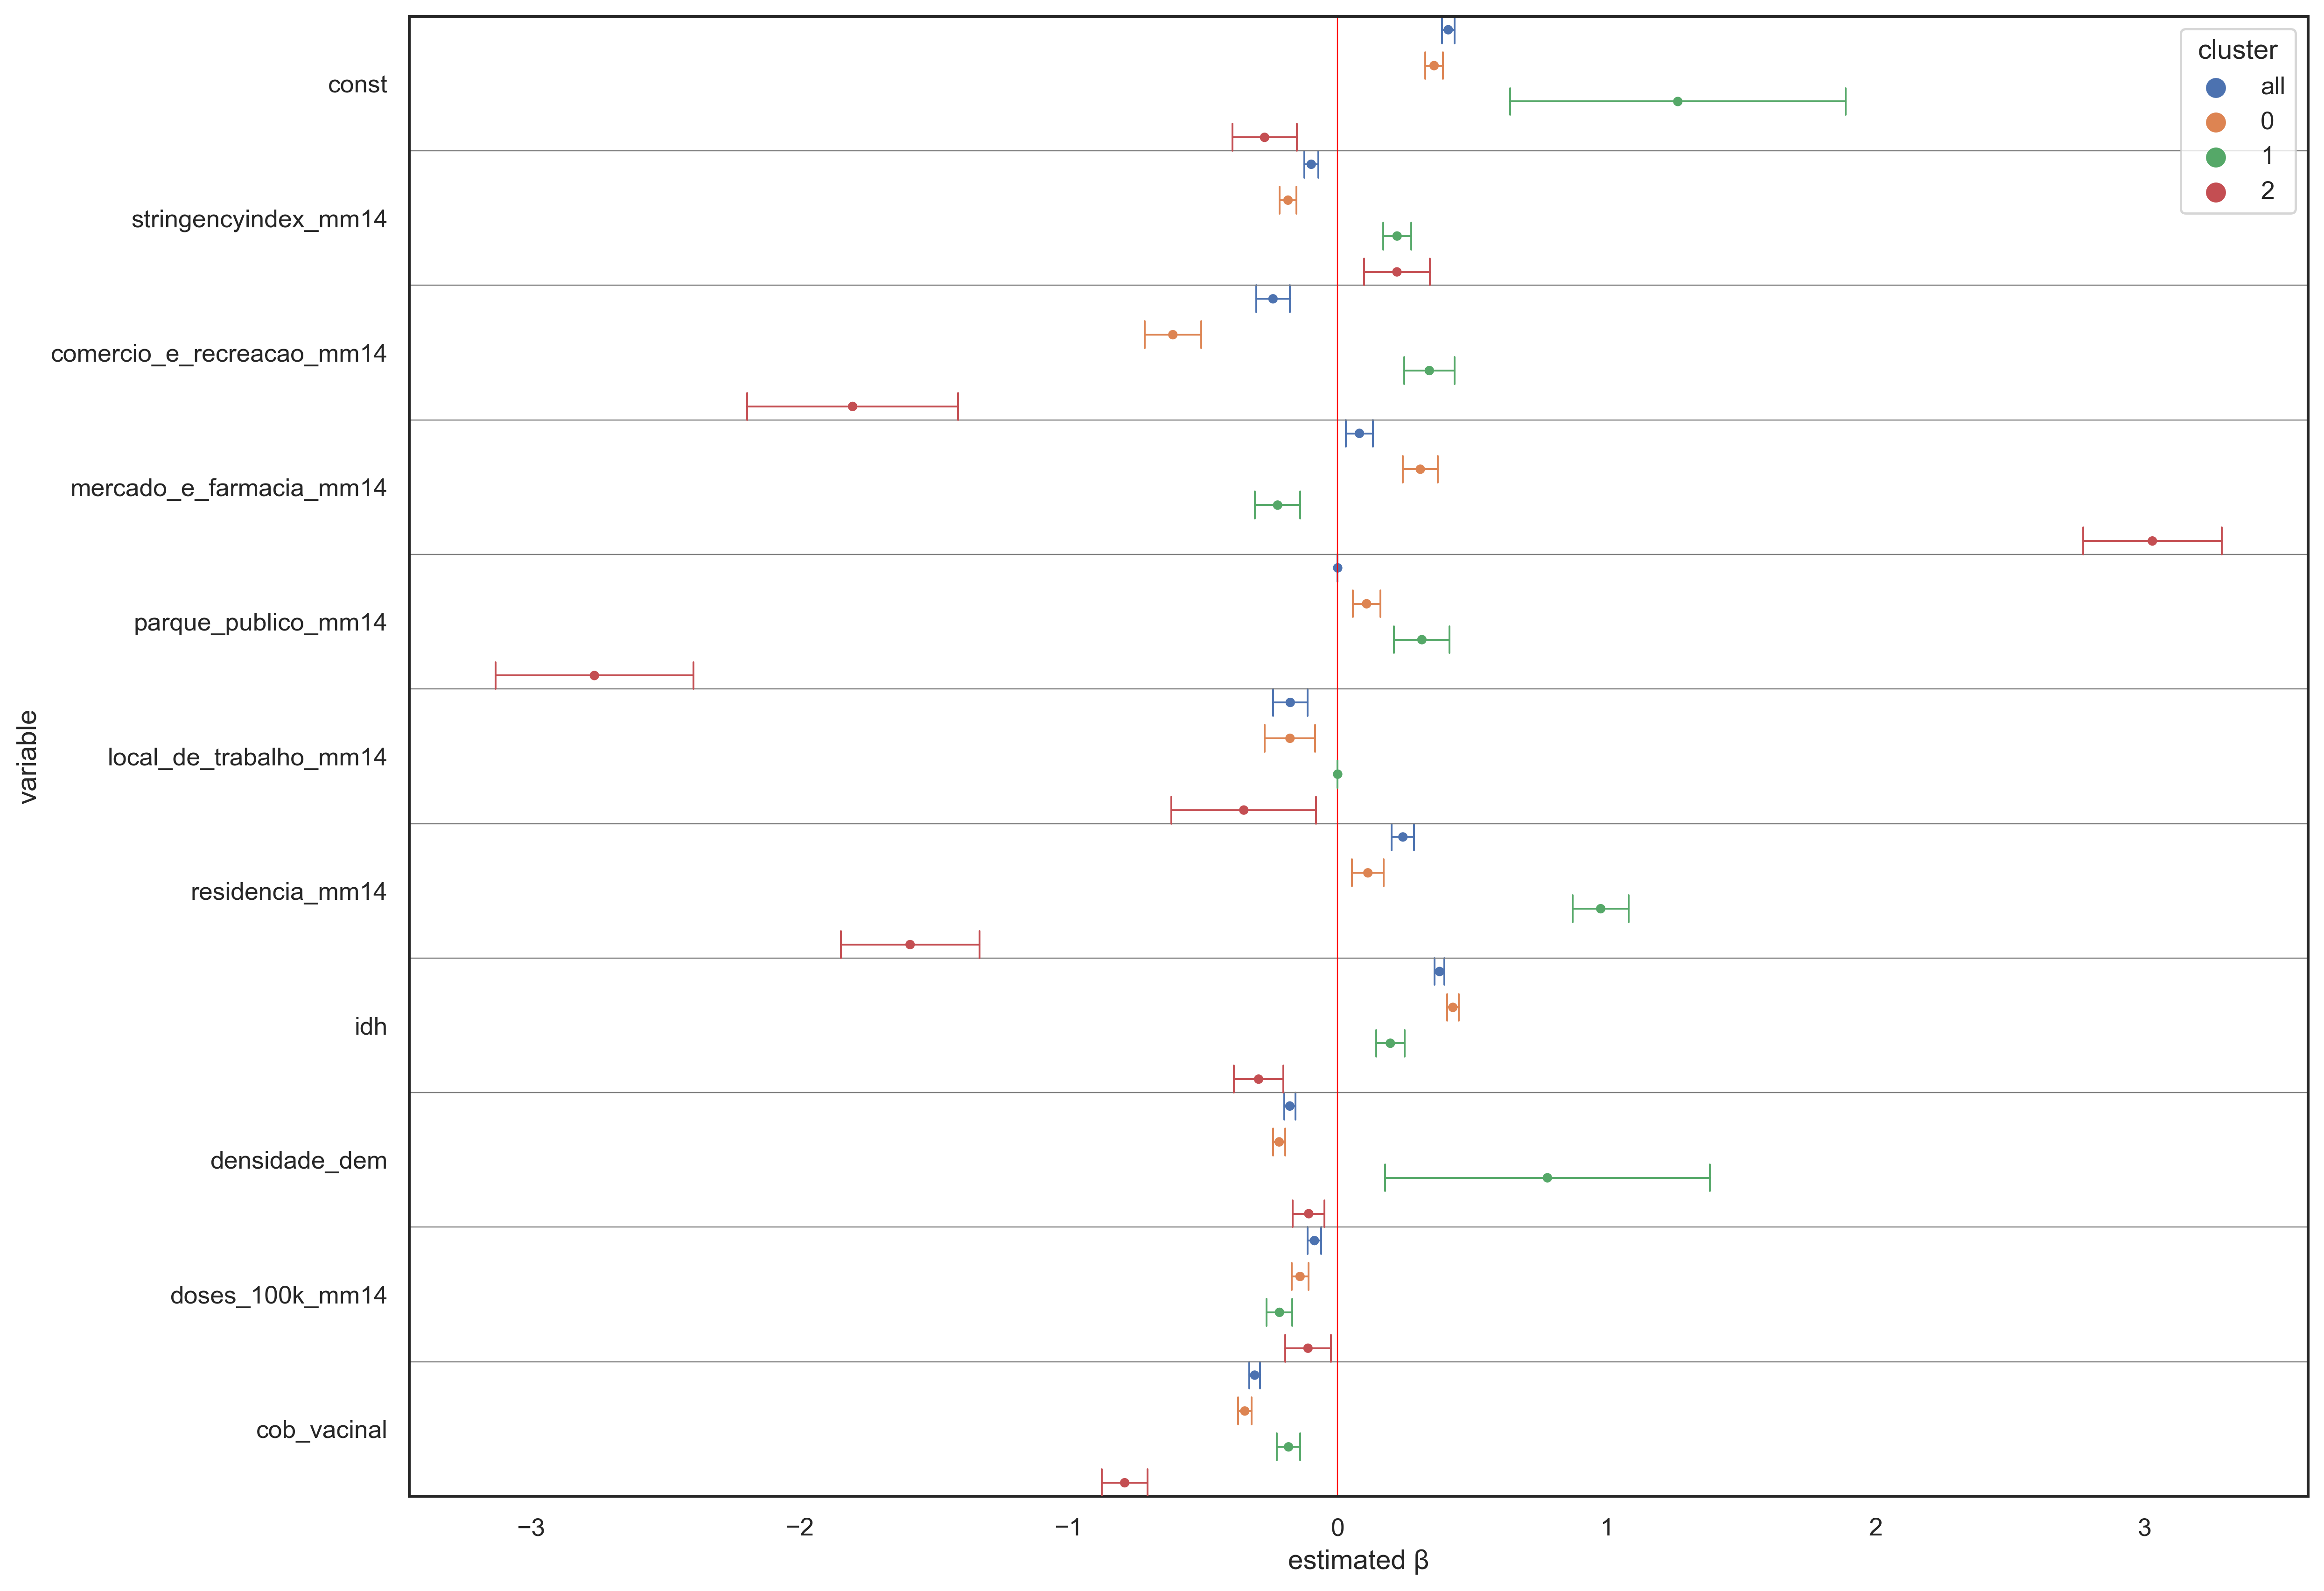

In [210]:
fig = plt.subplots(figsize=(15,12),dpi=350)
sns.set_theme(style="white")
ax = sns.pointplot(x="estimated \u03B2",y="variable",data=a,join = False,
                   hue = 'cluster',errwidth=0.8,capsize=0.2, dodge = 0.8)

for i in range(4):
    points = ax.collections[i]
    size = points.get_sizes().item()
    new_sizes = [size * 0.1 for name in ax.get_yticklabels()]
    points.set_sizes(new_sizes)
for i in range(12):
    ax.axhline((i-1/2),linewidth=0.5, color = 'grey')
ax.axvline(0,linewidth=0.5,color="red")

plt.show()

In [ ]:
coefs[0].index